# homework 5

In [1]:
import numpy as np
from scipy import integrate
from scipy import interpolate
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Samples for each dose level
n_samples = 5 * np.ones(4, dtype=int)
# Log-dose
dose = np.array([-.86, -.3, -.05, .73])
deaths=np.array([0, 1, 3, 5])

p_posterior is proportional to the posterior probability of alpha and beta given the observed data.  The model is that $logit(\theta)=\alpha+dose*\beta$, where theta is the probablity of death for the log drug concentration dose.

$$logit(p)=\log\left( \frac{p}{1-p} \right) =\log(p)-\log(1-p)=-\log\left( \frac{1}{p} - 1\right)$$

The $logit$ function is often used to stretch the value space of a variable that has a range from 0 to 1 (for example a probability).

As you can see below, for each dose the likelihood of the data to be observed $deaths_i$ given the probability of death $\theta_i$ and the number of tries $n_i$:

$$P( deaths_{i} \mid n_{i},\theta_{i}) \propto  \theta_{i}^{deaths_{i}}(1-\theta_{i})^{n_{i}-deaths_{i}}$$

The combined likelihood is the product of all experimental outcomes:

$$P( \{deaths_{i}\} \mid \{n_{i},\theta_{i}\}) \propto  \prod_{i}\theta_{i}^{deaths_{i}}(1-\theta_{i})^{n_{i}-deaths_{i}}$$

In order to use the function with alpha, beta being two-dimensional matrices and dose,obs_deaths and n being one-dimensional arrays, I was forced to interate over dose and then take the product over the first axis.  Let me know if there is an easier and more elegant way.

In [3]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

def p_posterior(alpha,beta,dose,obs_deaths,n):
    p=[]
    for dose_i,obs_deaths_i,n_i in zip(dose,obs_deaths,n):
        theta_i=invlogit(alpha+beta*dose_i)
        p.append(theta_i**obs_deaths_i*(1-theta_i)**(n_i-obs_deaths_i))
    p=np.array(p)
    return np.prod(p,axis=0)

We also need to define a function to calculate the inverse cummulative distribution function

In [4]:
# calculate inverse cummulative distribution function for sampling
def inv_cdf(pdf,x):
    cdf_pdf=[integrate.simps(pdf[:i+1],x[:i+1]) for i in range(len(x)-1)]
    cdf_pdf=np.array([0.0]+cdf_pdf)
    cdf_pdf=cdf_pdf/cdf_pdf[-1]
    return interpolate.interp1d(cdf_pdf,x)

Now lets calculate the posterior probablity over a grid of points

In [5]:
delta = 0.1
alpha = np.arange(-5.0, 10.0+delta, delta)
beta = np.arange(-10.0, 40+delta, delta)
ALPHA, BETA = np.meshgrid(alpha, beta)
P = p_posterior(ALPHA,BETA,dose,deaths,n_samples)

(0, 25)

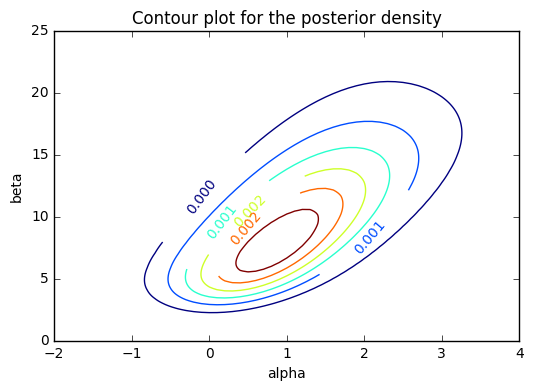

In [6]:
plt.figure()
CS = plt.contour(ALPHA, BETA, P)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Contour plot for the posterior density')
plt.xlabel('alpha')
plt.ylabel('beta')
plt.xlim((-2,4))
plt.ylim((0,25))

we can now calculate the average alpha and beta distributions by averaging over the other direction

In [7]:
# average distributions
alpha_pro=np.mean(P,axis=0)
beta_pro=np.mean(P,axis=1)

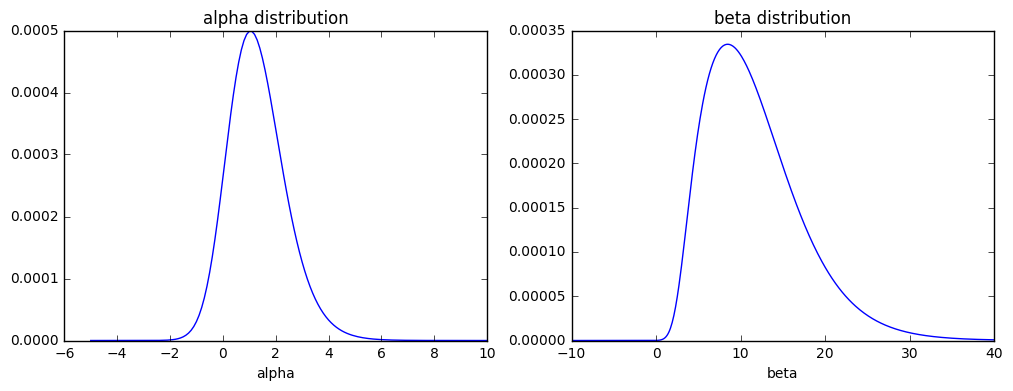

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(alpha,alpha_pro)
plt.xlabel('alpha')
plt.title('alpha distribution')
plt.subplot(1,2,2)
plt.plot(beta,beta_pro)
plt.xlabel('beta')
plt.title('beta distribution')

In this example we will employ a Metropolis sampler that we start with a random sample from the average alpha distribution.
We sampling using the inverse-cdf method that is described in Gelman's book. 

The proposal distribution is 
$$f(x,y)=\frac{1}{2\pi{\sigma}^2}exp\left[-\frac{(x-\mu)^2+(y-\nu)^2}{2\sigma^2}\right]$$
When $\sigma=1$, the proposal distribution can be written as
$$f_1(x,y)=\frac{1}{2\pi}exp\left[-\frac{(x-\mu)^2+(y-\nu)^2}{2}\right]$$


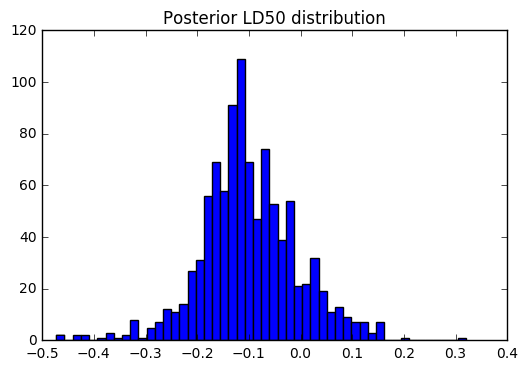

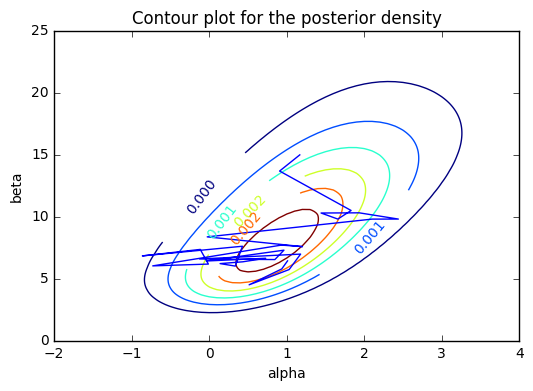

In [26]:
n=1000
# Starting point for MCMC sampler is drawn from average alpha
alpha0=inv_cdf(alpha_pro,alpha)(np.random.random())
beta0=inv_cdf(p_posterior(alpha0,beta,dose,deaths,n_samples),beta)(np.random.random())
#alpha1=inv_cdf(alpha_pro,alpha)(np.random.random())
#beta1=inv_cdf(p_posterior(alpha1,beta,dose,deaths,n_samples),beta)(np.random.random())

# your implementation of MCMC should go here


alpha_sampling=[alpha0]
beta_sampling=[beta0]

for i in range(n):
    #alphai=inv_cdf(gauss(alpha_sampling,beta_sampling[-1]),alpha_sampling)(np.random.random())
    parai=np.random.multivariate_normal([alpha_sampling[-1],beta_sampling[-1]],[[1,0],[0,1]])
    alphai,betai=parai[0],parai[1]
    if p_posterior(alphai,betai,dose,deaths,n_samples)>=p_posterior(alpha_sampling[-1],beta_sampling[-1],dose,deaths,n_samples): 
        alpha_sampling.append(alphai)
        beta_sampling.append(betai)
    elif np.random.random()<=p_posterior(alphai,betai,dose,deaths,n_samples)/p_posterior(alpha_sampling[-1],beta_sampling[-1],dose,deaths,n_samples):
        alpha_sampling.append(alphai)
        beta_sampling.append(betai)
    else:
        alpha_sampling.append(alpha_sampling[-1])
        beta_sampling.append(beta_sampling[-1])
    #betai=inv_cdf(gauss(alpha_sampling[-1],beta_sampling),beta_sampling)(np.random.random())
    #if p_posterior(alpha_sampling[-1],betai,dose,deaths,n_samples)>=p_posterior(alpha_sampling[-1],beta_sampling[-1],dose,deaths,n_samples): 
        #beta_sampling.append(betai)
    #elif np.random.random()<=p_posterior(alpha_sampling[-1],betai,dose,deaths,n_samples)/p_posterior(alpha_sampling[-1],beta_sampling[-1],dose,deaths,n_samples):
        #beta_sampling.append(betai)
        
beta_sampling=np.array(beta_sampling)
alpha_sampling=np.array(alpha_sampling)
    
ld50=-alpha_sampling/beta_sampling

plt.figure(1)
plt.hist(ld50,bins=50)
plt.title('Posterior LD50 distribution')

plt.figure(2)
CS = plt.contour(ALPHA, BETA, P)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Contour plot for the posterior density')
plt.xlabel('alpha')
plt.ylabel('beta')
plt.xlim((-2,4))
plt.ylim((0,25))
plt.plot(alpha_sampling[:50], beta_sampling[:50])
plt.show()

In [10]:
print(np.percentile(ld50,[2.5,25,50,75,97.5]))

[-0.29854955 -0.17116548 -0.11720151 -0.07078959  0.2444098 ]


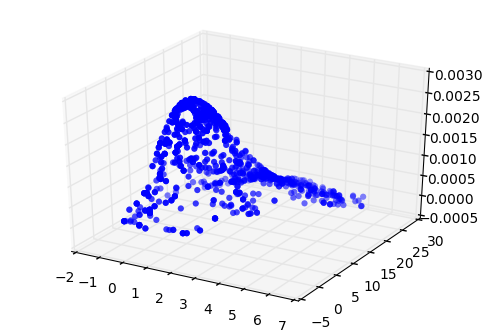

In [11]:
from mpl_toolkits.mplot3d import Axes3D
px=[]
py=[]
gxy=[]
#print(parai,end='\n')
for i in range(n):
    px.append(alpha_sampling[i])
    py.append(beta_sampling[i])
px=np.array(px)
py=np.array(py)
PX,PY=np.meshgrid(px,py)
#gxy=gauss(px,py,alpha_sampling[-1],beta_sampling[-1])
post = p_posterior(px,py,dose,deaths,n_samples)
POST = p_posterior(PX,PY,dose,deaths,n_samples)

figure=plt.figure()
#ax = Axes3D(figure)
#ax.plot_surface(PX, PY, POST, rstride=1, cstride=1, cmap='rainbow')

ax = figure.add_subplot(111, projection='3d')
ax.scatter(px,py,post,marker='o',linewidths=0)
plt.show()